# Lab 7: Sequential Network Architectures

## by Michael Doherty, Leilani Guzman, and Carson Pittman

"We've been trying to reach you about your car's extended warranty." There are few things more annoying in life than answering your phone and hearing these words. With technology being readily available to many people throughout the world, these types of scams have become much more prevalent. These "spam" messages, while not always scams, rarely add anything to society.

While advancing technology has allowed spam messages to increase in numbers over the years, it has also allowed for new ways to combat these messages. These spam detection filters can automatically block any incoming calls, emails, texts, etc. that appear to be suspicious; however, these filters need to be fairly refined, as blocking too many legitimate messages would lead to distrust in the filter's reliability.

Our dataset, titled "SMS Spam Collection Dataset", is comprised of over 5000 text messages in English, with each being tagged as either <code>spam</code> or <code>ham</code> (which means it's a legitimate message). Our task is to create a Sequential Network that can classify text messages as either <code>spam</code> or <code>ham</code>.

Link to the dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

## 1. Preparation
### 1.1 Preprocessing and Tokenization
To start, we'll first read in the data.

In [34]:
import pandas as pd

df = pd.read_csv("data/spam.csv", encoding='ISO-8859-1')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


As seen above, the dataset seems to include some useless columns... Let's go ahead and remove those. We'll also rename our remaining columns so their purpose is clearer.

In [35]:
df.drop(labels=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

df.rename(columns={'v1': 'Label', 'v2': 'Text'}, inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Now that our dataset is looking better, let's tokenize the words in our <code>Text</code> variable. **ADD MORE ABOUT SPECIFICALLY WHAT WE DO TO TOKENIZE**

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_review_length = 6000
tokenizer = Tokenizer(num_words=max_review_length)
tokenizer.fit_on_texts(df["Text"])

print("\nVocabulary:")
print(len(tokenizer.word_index))
VOCAB_SIZE = len(tokenizer.word_index) + 1

X = tokenizer.texts_to_sequences(df["Text"])
X = pad_sequences(X, padding='post')
# Represent spam as 1 and ham as 0
y = pd.get_dummies(df["Label"], drop_first=True).values

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)


Vocabulary:
8920

Shape of X: (5572, 189)
Shape of y: (5572, 1)


Now that we're done with preprocessing and tokenization, our final dataset can be described as follows:

**INSERT DATASET DESCRIPTION (SIMILIAR TO LAB 5)**

### 1.2 Performance Metric
Now that we have our final dataset, let's visualize the distribution of values for our target variable <code>Label</code>; this will help us determine a suitable performance metric for our models.

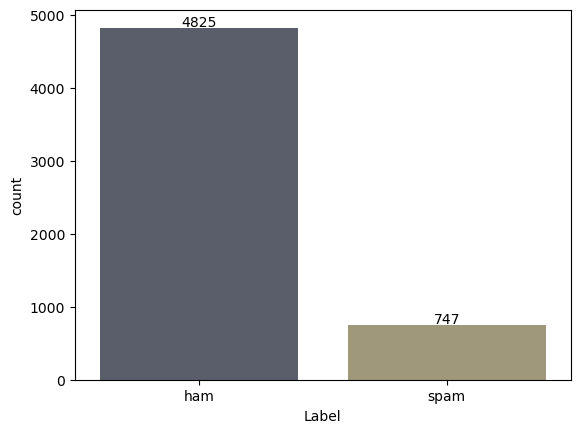

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x=df['Label'], palette='cividis')

for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.0f}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.xticks([0,1], ['ham', 'spam'])
plt.show()

As seen above, there are significantly more messages labeled as <code>ham</code> than <code>spam</code>; thus, accuracy would not be a good metric (as it would be skewed towards the <code>ham</code> label). For this classification task, we care about both precision (making sure the messages we label as <code>spam</code> are actually spam) and recall (making sure all spam messages are labeled as <code>spam</code>). 

Precision is important, as we don't want to label legitimate messages as <code>spam</code> (as this would annoy users and make them distrust the legitimacy of our model); however, recall is also important, as we want to identify as many spam messages as possible. After all, a highly precise model that only identifies 1 out of 100 spam messages as actually being spam isn't ideal. Thus, we will use **F1 Score** as our evaluation metric, as it takes both precision and recall into account.

### 1.3 Training and Testing Method

Now that we have our performance metric, we need to split our dataset into training and testing data. As we saw earlier, the labels in this dataset aren't balanced (as there are far more <code>ham</code> messages than <code>spam</code> messages). Thus, we will use StratifiedKFold to split our data into 5 splits for cross validation. StratifiedKFold ensures that each fold contains the same proportion of <code>ham</code> and <code>spam</code> messages. Furthermore, 5 splits allows for an 80/20 train test split (where our model trains on 80% of the data and uses the other 20% as validation data). Due to the large amount of data available to us, we believe this is sufficient.

We believe this cross validation method is a realistic mirroring of how an algorithm would be used in practice, as this dataset is public information available for anyone to use. The cross validations splits would need to be stratified due to the class imbalance in the dataset, and 5 folds is sufficient, as an 80/20 train test split is a common practice in machine learning.

In [67]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn import metrics as mt
import random
import numpy as np

mean_fpr = np.linspace(0, 1, 100)

def get_f1_score(X, y, new_model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    f1_scores = []
    mean_tpr_list = []
    auc_list = []
    yhats = []

    i = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # X_train = pad_sequences(X_train, maxlen=max_review_length)
        # X_test = pad_sequences(X_test, maxlen=max_review_length)

        # VOCAB_SIZE = X_train.shape[1]
        history, yhat = new_model(X_train, X_test, y_train, y_test)
        print(f"Fold {i}")
        i += 1

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(history.history['f1_metric'], label='training')

        plt.ylabel('F1 Score %')
        plt.title('Training')
        plt.plot(history.history['val_f1_metric'], label='validation')
        plt.title('F1 Score')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='training')
        plt.ylabel('Training Loss')
        plt.xlabel('epochs')

        plt.plot(history.history['val_loss'], label='validation')
        plt.xlabel('epochs')
        plt.title('Loss')
        plt.legend()
        plt.show()

        f1_scores.append(history.history['val_f1_metric'][-1])
        fpr, tpr, thresholds = roc_curve(y_test, yhat)
        mean_tpr_list.append(np.interp(mean_fpr, fpr, tpr))
        auc_list.append(auc(fpr, tpr))
        yhats.append(yhat)

    plt.bar(range(len(f1_scores)), f1_scores)
    plt.ylim([min(f1_scores) - 0.01, max(f1_scores)])
    plt.title('Validation F1 Score')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    print("Average F1 Score:", np.mean(f1_scores))
    
    return f1_scores, mean_tpr_list, auc_list

## 2. Modeling

### 2.1 Model Creation

#### 2.1.1 Model 1: CNN Sequential Network

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score, make_scorer
from tensorflow.keras import backend as K

NUM_CLASSES = 1
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    return tf.py_function(f1_score, (y_true, y_pred), tf.double)

def CNN_Seq(X_train, X_test, y_train, y_test):
    EMBED_SIZE = 100
    sequence_input = Input(shape=(X_train.shape[1],))

    embedded_sequences = Embedding(max_review_length,
                                    EMBED_SIZE,
                                    input_length=max_review_length)(sequence_input)
    
    x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(x)
    
    x = MaxPooling1D(5)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(x)
    x = Dropout(0.2)(x)

    x_mean = GlobalAveragePooling1D()(x)
    x_tmp = Subtract()([x,x_mean])
    x_std = GlobalAveragePooling1D()(x_tmp**2)

    x = Concatenate(name='concat_1')([x_mean,x_std])

    x = Dense(64, activation='relu',
                kernel_initializer='he_uniform')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(NUM_CLASSES, activation='sigmoid',
                        kernel_initializer='glorot_uniform')(x)
    
    cnn = Model(sequence_input, predictions)
    cnn.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])

    history = cnn.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                    verbose=0)
    
    yhat = np.round(cnn.predict(X_test))

    return history, yhat

c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c

35/35 [==============================] - 0s 7ms/step
Fold 1


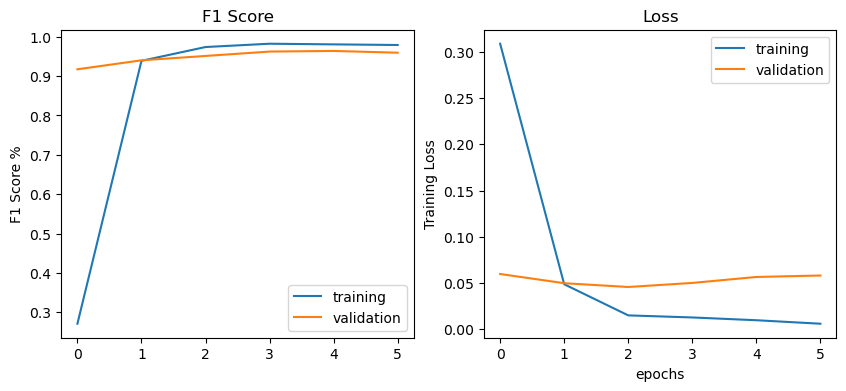

c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c

35/35 [==============================] - 0s 7ms/step
Fold 2


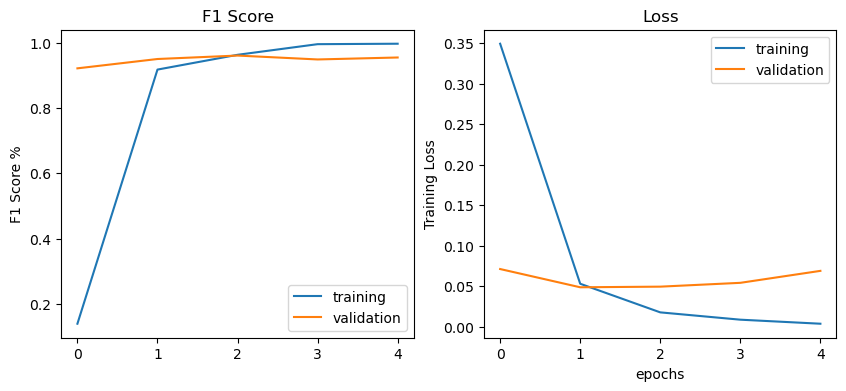

c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c

35/35 [==============================] - 0s 8ms/step
Fold 3


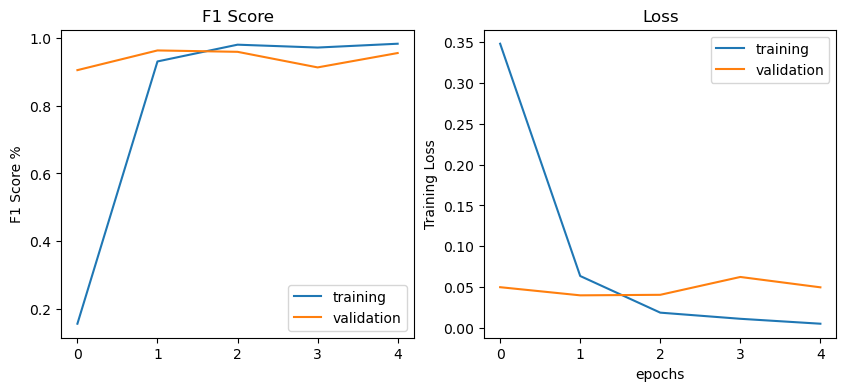

c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c

35/35 [==============================] - 0s 6ms/step
Fold 4


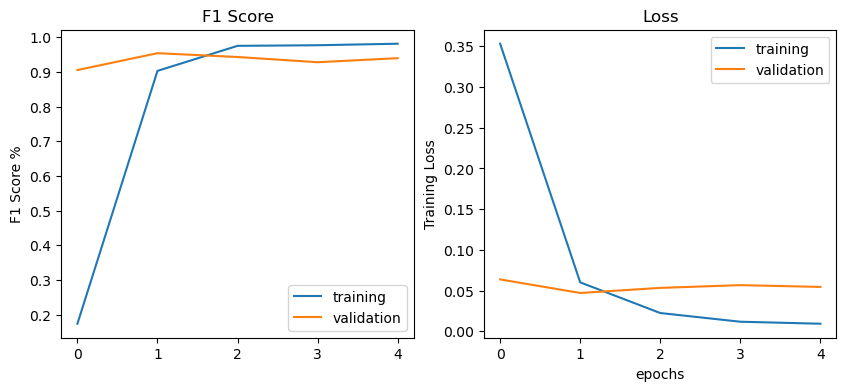

c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\leila\anaconda3\envs\mlenv2023\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c

35/35 [==============================] - 0s 6ms/step
Fold 5


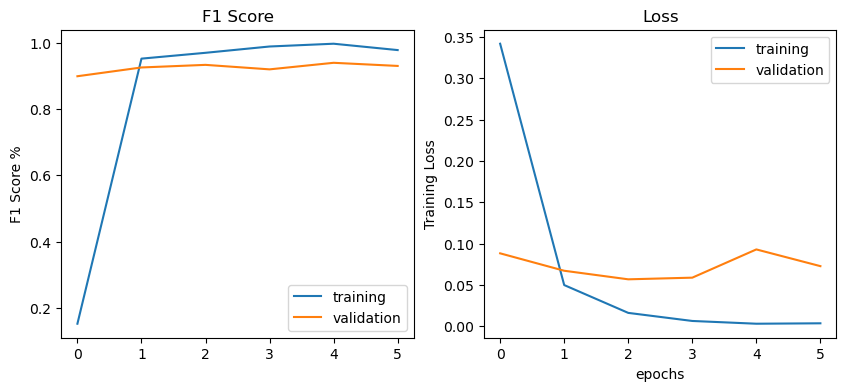

Average F1 Score: 0.9475690007209778


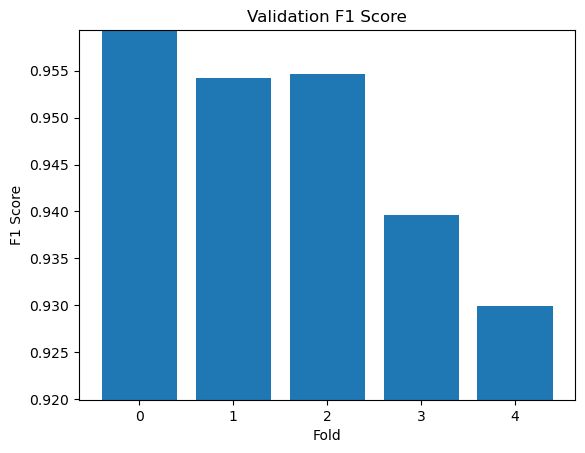

In [42]:
f1_scores, mean_tpr_list, auc_list = get_f1_score(X, y, CNN_Seq)

#### 2.1.2 Model 2: Transformer Sequential Network

In [46]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer


# The transformer architecture
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # Setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embed_dim)
       
        # Make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
       
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)


    def call(self, inputs, training):
        # Apply the layers as needed
        # Get the attention output from multi heads
        # Using same inpout here is self-attention
        # Call inputs are (query, value, key)
        # If only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
       
        # Create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
       
        # Apply dropout if training
        out1 = self.dropout1(out1, training=training)
       
        # Place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
       
        # Apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size,
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen,
                                 output_dim=embed_dim)


    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [49]:
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

def seq_transformer(X_train, X_test, y_train, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = TokenAndPositionEmbedding(X_train.shape[1], VOCAB_SIZE, embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='sigmoid',
                kernel_initializer='glorot_uniform')(x)


    xformer = Model(inputs=inputs, outputs=outputs)

    xformer.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])

    history = xformer.fit(
        X_train, y_train, batch_size=64, epochs=5,
        validation_data=(X_test, y_test), verbose=0,
    )

    yhat = np.round(xformer.predict(X_test))

    return history

Epoch 1/5
70/70 [==============================] - 13s 166ms/step - loss: 0.4260 - binary_accuracy: 0.8604 - f1_metric: 0.0084 - val_loss: 0.3558 - val_binary_accuracy: 0.8655 - val_f1_metric: 0.0000e+00
Epoch 2/5
70/70 [==============================] - 22s 310ms/step - loss: 0.2229 - binary_accuracy: 0.9188 - f1_metric: 0.4390 - val_loss: 0.0587 - val_binary_accuracy: 0.9812 - val_f1_metric: 0.9202
Epoch 3/5
70/70 [==============================] - 27s 360ms/step - loss: 0.0509 - binary_accuracy: 0.9888 - f1_metric: 0.9563 - val_loss: 0.0455 - val_binary_accuracy: 0.9883 - val_f1_metric: 0.9532
Epoch 4/5
70/70 [==============================] - 13s 180ms/step - loss: 0.0220 - binary_accuracy: 0.9951 - f1_metric: 0.9821 - val_loss: 0.0664 - val_binary_accuracy: 0.9857 - val_f1_metric: 0.9400
Epoch 5/5
35/35 [==============================] - 1s 27ms/step
Fold 1


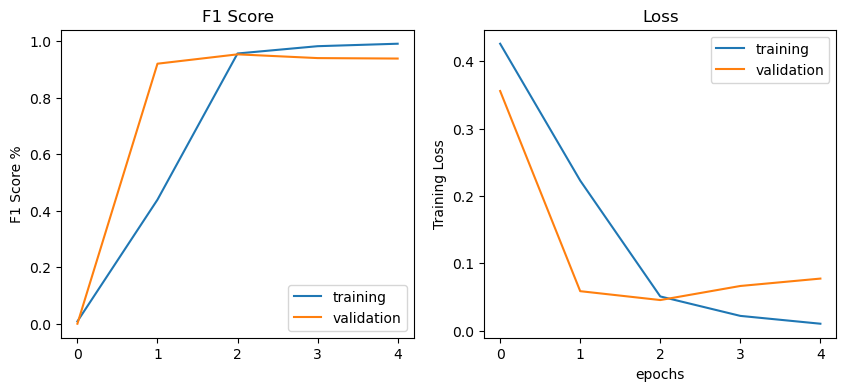

Epoch 1/5
70/70 [==============================] - 12s 151ms/step - loss: 0.4168 - binary_accuracy: 0.8519 - f1_metric: 0.0115 - val_loss: 0.3616 - val_binary_accuracy: 0.8655 - val_f1_metric: 0.0000e+00
Epoch 2/5
70/70 [==============================] - 41s 598ms/step - loss: 0.2457 - binary_accuracy: 0.9053 - f1_metric: 0.3403 - val_loss: 0.0575 - val_binary_accuracy: 0.9865 - val_f1_metric: 0.9476
Epoch 3/5
70/70 [==============================] - 14s 179ms/step - loss: 0.0499 - binary_accuracy: 0.9874 - f1_metric: 0.9476 - val_loss: 0.0450 - val_binary_accuracy: 0.9901 - val_f1_metric: 0.9609
Epoch 4/5
70/70 [==============================] - 47s 683ms/step - loss: 0.0188 - binary_accuracy: 0.9953 - f1_metric: 0.9817 - val_loss: 0.0518 - val_binary_accuracy: 0.9910 - val_f1_metric: 0.9671
Epoch 5/5
35/35 [==============================] - 1s 32ms/step
Fold 2


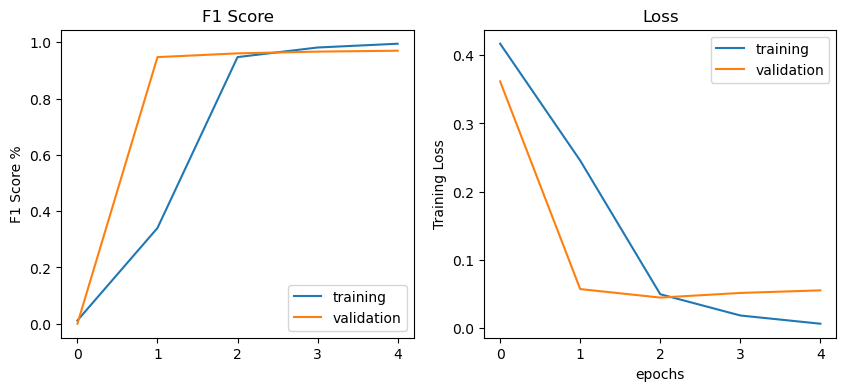

Epoch 1/5
70/70 [==============================] - 10s 117ms/step - loss: 0.3801 - binary_accuracy: 0.8647 - f1_metric: 0.0067 - val_loss: 0.2700 - val_binary_accuracy: 0.9452 - val_f1_metric: 0.6972
Epoch 2/5
70/70 [==============================] - 9s 127ms/step - loss: 0.1338 - binary_accuracy: 0.9554 - f1_metric: 0.7485 - val_loss: 0.0326 - val_binary_accuracy: 0.9919 - val_f1_metric: 0.9485
Epoch 3/5
70/70 [==============================] - 9s 127ms/step - loss: 0.0441 - binary_accuracy: 0.9886 - f1_metric: 0.9509 - val_loss: 0.0349 - val_binary_accuracy: 0.9919 - val_f1_metric: 0.9472
Epoch 4/5
70/70 [==============================] - 9s 130ms/step - loss: 0.0250 - binary_accuracy: 0.9933 - f1_metric: 0.9737 - val_loss: 0.0280 - val_binary_accuracy: 0.9946 - val_f1_metric: 0.9726
Epoch 5/5
35/35 [==============================] - 1s 30ms/step
Fold 3


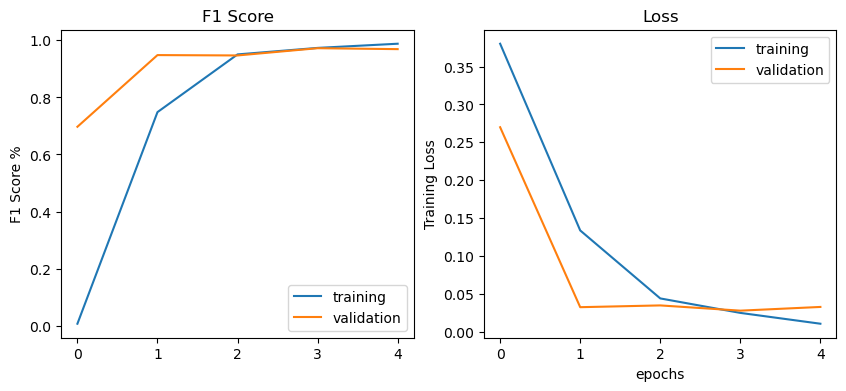

Epoch 1/5
70/70 [==============================] - 11s 126ms/step - loss: 0.4283 - binary_accuracy: 0.8551 - f1_metric: 0.0023 - val_loss: 0.3632 - val_binary_accuracy: 0.8662 - val_f1_metric: 0.0000e+00
Epoch 2/5
70/70 [==============================] - 10s 143ms/step - loss: 0.2510 - binary_accuracy: 0.8939 - f1_metric: 0.2681 - val_loss: 0.0889 - val_binary_accuracy: 0.9794 - val_f1_metric: 0.9061
Epoch 3/5
70/70 [==============================] - 10s 143ms/step - loss: 0.0572 - binary_accuracy: 0.9845 - f1_metric: 0.9347 - val_loss: 0.0543 - val_binary_accuracy: 0.9794 - val_f1_metric: 0.9098
Epoch 4/5
70/70 [==============================] - 10s 146ms/step - loss: 0.0262 - binary_accuracy: 0.9928 - f1_metric: 0.9680 - val_loss: 0.0486 - val_binary_accuracy: 0.9883 - val_f1_metric: 0.9449
Epoch 5/5
35/35 [==============================] - 1s 32ms/step
Fold 4


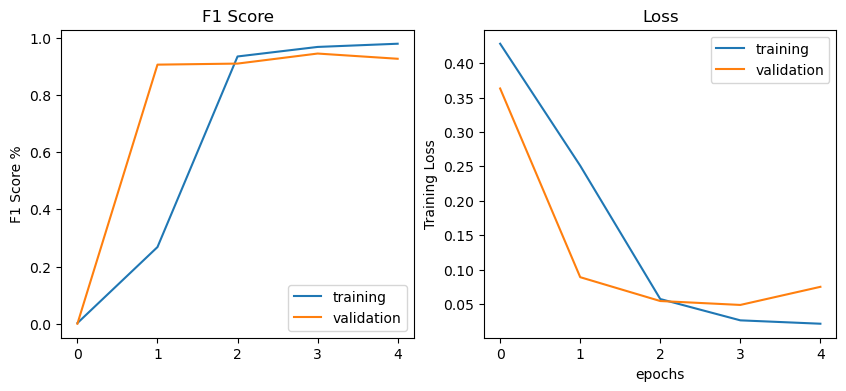

Epoch 1/5
70/70 [==============================] - 16s 187ms/step - loss: 0.4087 - binary_accuracy: 0.8594 - f1_metric: 0.0062 - val_loss: 0.3553 - val_binary_accuracy: 0.8662 - val_f1_metric: 0.0000e+00
Epoch 2/5
70/70 [==============================] - 18s 252ms/step - loss: 0.2227 - binary_accuracy: 0.9038 - f1_metric: 0.3226 - val_loss: 0.1225 - val_binary_accuracy: 0.9740 - val_f1_metric: 0.8968
Epoch 3/5
70/70 [==============================] - 17s 241ms/step - loss: 0.0480 - binary_accuracy: 0.9895 - f1_metric: 0.9575 - val_loss: 0.1335 - val_binary_accuracy: 0.9686 - val_f1_metric: 0.8709
Epoch 4/5
70/70 [==============================] - 16s 231ms/step - loss: 0.0241 - binary_accuracy: 0.9937 - f1_metric: 0.9744 - val_loss: 0.0732 - val_binary_accuracy: 0.9829 - val_f1_metric: 0.9249
Epoch 5/5
35/35 [==============================] - 1s 28ms/step
Fold 5


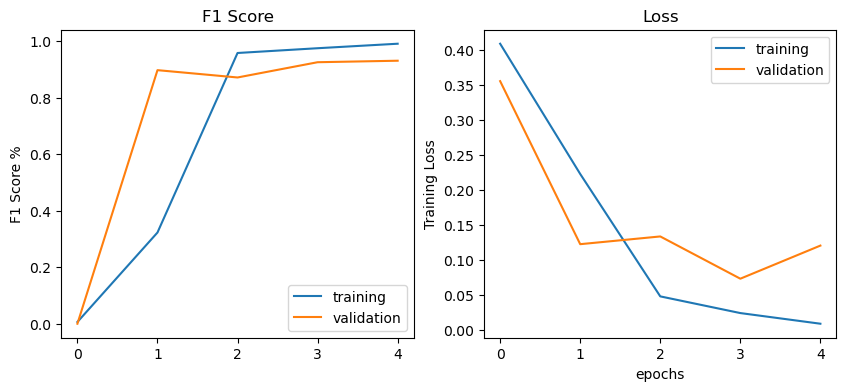

Average F1 Score: 0.9469794750213623


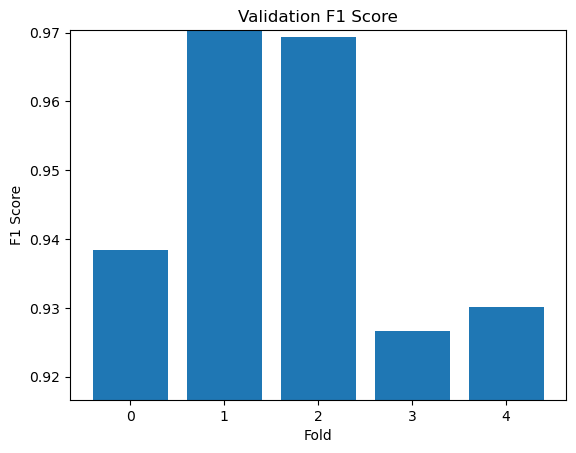

In [50]:
f1_scores, mean_tpr_list, auc_list = get_f1_score(X, y, seq_transformer)

#### 2.1.3 Model 3: Modified CNN Sequential Network

#### 2.1.4 Model 4: Modified Transformer Sequential Network

### 2.2 Adding Second Attention Layer to the Transformer

In [68]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer


# The transformer architecture
class TransformerBlock2(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # Setup the model heads and feedforward network
        self.att1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embed_dim)
        # Adding second attention layer
        self.att2 = MultiHeadAttention(num_heads=num_heads,
                                        key_dim=embed_dim)
       
        # Make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
       
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)


    def call(self, inputs, training):
        attn_output1 = self.att1(inputs, inputs)
       
        # Create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output1)
        out1 = self.dropout1(out1, training=training)
       
        attn_output2 = self.att2(out1, out1)
        out2 = self.layernorm2(out1 + attn_output2)
        out2 = self.dropout2(out2, training=training)

        # Place through feed forward after layer norm
        ffn_output = self.ffn(out2)
        out3 = self.layernorm3(out2 + ffn_output)
        out3 = self.dropout3(out3, training=training)
        #return the residual from Dense layer
        return out3

class TokenAndPositionEmbedding2(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size,
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen,
                                 output_dim=embed_dim)


    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [71]:
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# Transformer with a second mulit-head attention layer
def seq_transformer2(X_train, X_test, y_train, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = TokenAndPositionEmbedding2(X_train.shape[1], VOCAB_SIZE, embed_dim)(inputs)
    x = TransformerBlock2(embed_dim, num_heads, ff_dim)(x)
    x = TransformerBlock2(embed_dim, num_heads, ff_dim)(x) # Adding second attention layer

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='sigmoid',
                kernel_initializer='glorot_uniform')(x)


    xformer = Model(inputs=inputs, outputs=outputs)

    xformer.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])

    history = xformer.fit(
        X_train, y_train, batch_size=64, epochs=5,
        validation_data=(X_test, y_test), verbose=0,
    )

    yhat = np.round(xformer.predict(X_test))

    return history, yhat

35/35 [==============================] - 7s 186ms/step
Fold 1


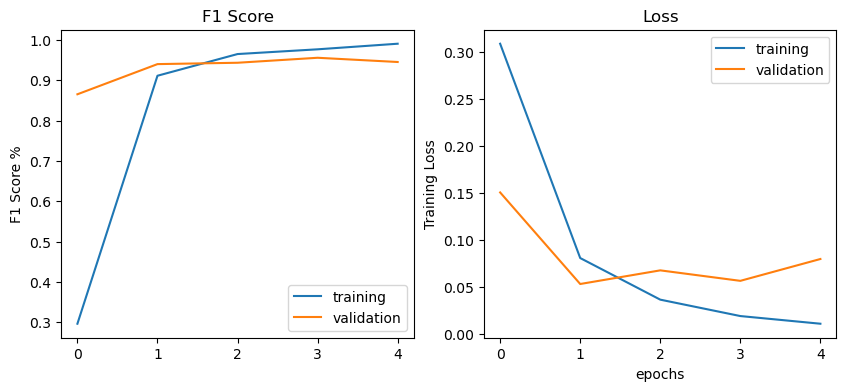

35/35 [==============================] - 7s 173ms/step
Fold 2


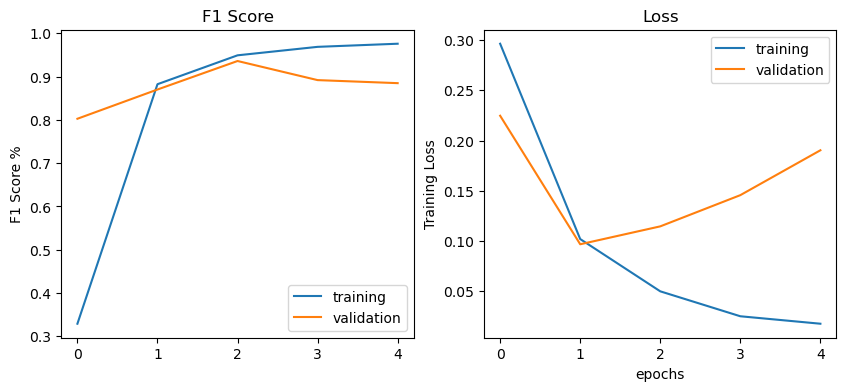

35/35 [==============================] - 5s 125ms/step
Fold 3


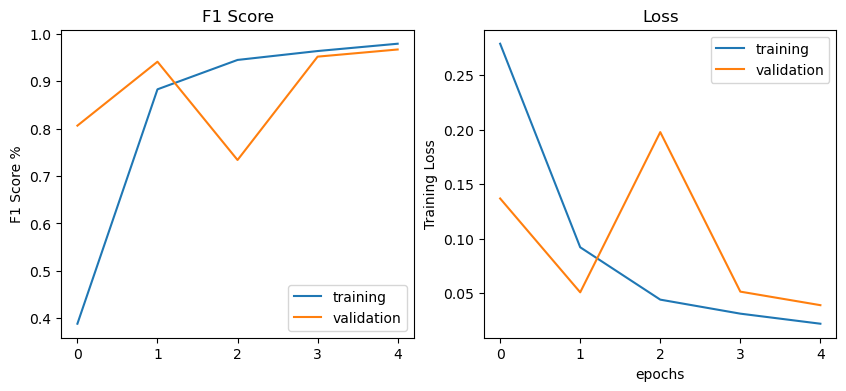

35/35 [==============================] - 5s 128ms/step
Fold 4


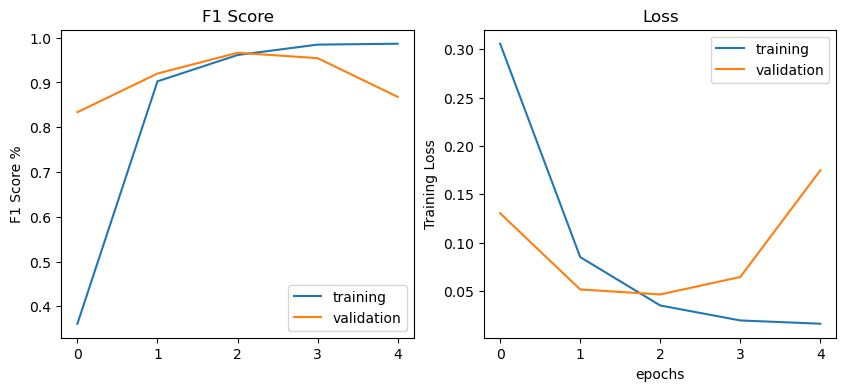

35/35 [==============================] - 5s 128ms/step
Fold 5


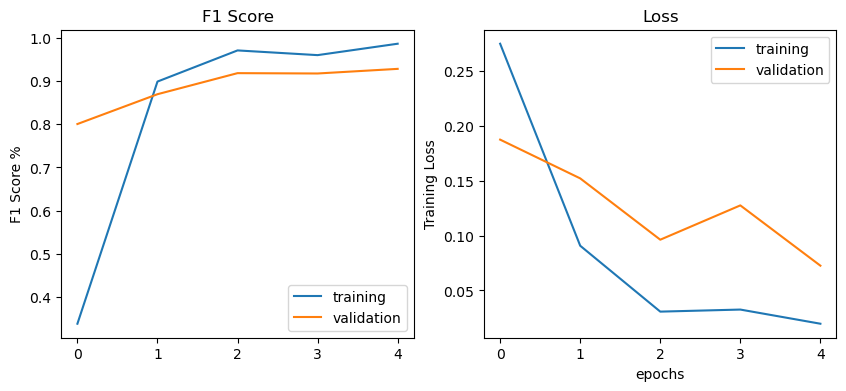

Average F1 Score: 0.9187266945838928


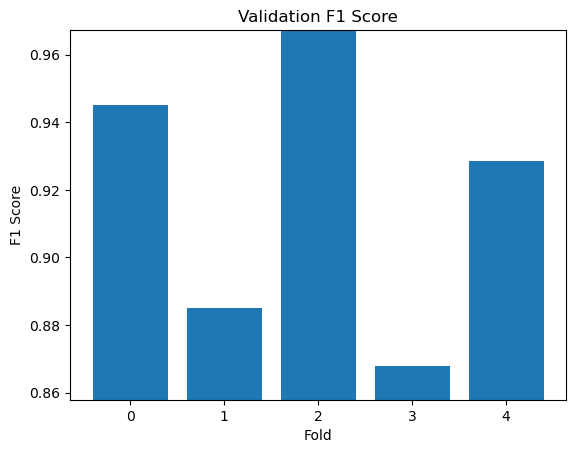

In [72]:
f1_scores, mean_tpr_list, auc_list = get_f1_score(X, y, seq_transformer2)

### 2.3 Model Comparison

## 3. ConceptNet Numberbatch vs. GloVe